In [29]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import IPython.display as ipd
import math
import csv

MAX_AUDIO_DURATION_MS = 4 * 1000
MAX_SAMPLE_COMPARISON_COUNT = 1000

apppath = os.path.expanduser(os.getcwd() + '/')
processedpath = os.path.join(apppath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
normalizedpath = os.path.join(processedpath, 'normalized/')
dtwpath = os.path.join(processedpath, 'dtw/')
excludedpath = os.path.join(processedpath, 'excluded/')
extensionpath = os.path.join(apppath, 'Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/downloads/')
metadatapath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/metadata/')
metadatacsvpath = os.path.join(apppath, 'processed/metadata.csv')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'

for p in [processedpath, soxipath, wavpath, audiopath, normalizedpath, dtwpath, excludedpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [30]:
ids = [f for f in os.listdir(metadatapath)]
print(len(ids))

if not os.path.exists(metadatacsvpath):
    fieldnames = ['id', 'duration', 'downloads', 'rating', 'numratings', 'tags']
    rows = []

    for id in ids:        
        with open(metadatapath + "/" + id) as file:
            try:
                id = int(id)
                line = file.readlines()[0]
                arguments = line.split('|')
                duration = int(arguments[0].split('duration:')[1])
                downloads = int(arguments[1].split('downloads:')[1])
                rating = int(arguments[2].split('rating:')[1])
                numratings = int(arguments[3].split('numratings:')[1])
                tags = arguments[4].split('tags:')[1]
                row = {
                    'id': id,
                    'duration': duration,
                    'downloads': downloads,
                    'rating': rating,
                    'numratings': numratings,
                    'tags': tags
                }
                rows.append(row)
            except Exception as e:
                print(e)

    with open(metadatacsvpath, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(rows)
        
def read_csv(filename):
    with open(filename) as f:
        file_data = csv.reader(f)
        headers = next(file_data)
        return [dict(zip(headers, i)) for i in file_data] 

metadata = read_csv(metadatacsvpath)

68455


In [31]:
excluded = [f for f in os.listdir(excludedpath)]
excluded = [f for f in excluded if f.endswith(audiofileformat)]
excluded = [f.split('.' + audiofileformat)[0] for f in excluded]

print(len(excluded))

971


In [32]:
DOWNLOADS_THRESHOLD = 25
RATING_THRESHOLD = 80
MIN_NUMRATINGS = 4

scored = []
for sample in metadata:            
    id = sample['id']
    if id in excluded:
        continue

    duration = int(sample['duration'])
    downloads = int(sample['downloads'])
    rating = int(sample['rating'])
    numratings = int(sample['numratings'])
    tags = sample['tags']

    if len(tags) > 0 and downloads >= DOWNLOADS_THRESHOLD and rating >= RATING_THRESHOLD and numratings >= MIN_NUMRATINGS:
        row = [id, duration, downloads, rating, numratings, tags, rating * downloads]
        scored.append(row)

print(len(scored))

scored.sort(key=lambda x: int(x[6]))
scored.reverse()

print(scored[0])

2499
['60009', 319, 67854, 86, 561, 'zoom-h2,domain,public,punch,swhish,swish,swoosh,swosh,whip,whoosh,woosh,stick,swash,zoom,swing,wind,wisch,attack,bamboo,cut,wish,flup,h2,luft,weapon,public-domain,air', 5835444]


In [33]:
samples = {}

for row in scored:
    id = row[0]
    samples[id] = {
        'duration': row[1],
        'downloads': row[2],
        'rating': row[3],
        'numratings': row[4],
        'tags': row[5],
        'score': row[6],
    }
    
print(samples[scored[0][0]])

{'duration': 319, 'downloads': 67854, 'rating': 86, 'numratings': 561, 'tags': 'zoom-h2,domain,public,punch,swhish,swish,swoosh,swosh,whip,whoosh,woosh,stick,swash,zoom,swing,wind,wisch,attack,bamboo,cut,wish,flup,h2,luft,weapon,public-domain,air', 'score': 5835444}


In [34]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
filtered = []

for filename in filenames:
    id = filename.split('__')[0]
    
    for row in scored:
        if row[0] == id:
            filtered.append(filename)
filenames = filtered
print('filtered filenames', len(filenames))

fileformats {'flac': 2888, 'wav': 46250, 'mp3': 2936, 'aiff': 19174, 'ogg': 679, 'm4a': 142, 'crdownload': 15, 'DS_Store': 1}
all_filenames: 72085
filtered filenames 2495


In [35]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [36]:
def process(command, cwd="/"):
    subprocess.check_output(command, cwd=cwd)

res = []
for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + audiofileformat
        
        if samples[fileid]['duration'] > MAX_AUDIO_DURATION_MS:
            continue

        if audiofilename not in processedfilenames:
            process(['ffmpeg-normalize', librarypath + filename, '-o', normalizedpath + filename])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
        res.append(audiofilename)
    except Exception as e:
        print(e)

filenames = res
print(filenames)
print(len(filenames))

ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512389__kievinay__bass-impact-ki-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/512389__kievinay__bass-impact-ki-01.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60015__qubodup__writing-z-for-zorro-in-the-air.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-19.73:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-30.48:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/2el2ikx4.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60015__qubodup__writing-z-for-zorro-in-the-air.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-19.73:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-30.48:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60015__qubodup__writing-z-for-zorro-in-the-air.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60015__qubodup__writing-z-for-zorro-in-the-air.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/453333__kyles__metal-crank-groan.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-4.35:measured_i=-16.65:measured_lra=0.9:measured_tp=-4.85:measured_thresh=-30.54:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pgf9bgbh.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/453333__kyles__metal-crank-groan.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-4.35:measured_i=-16.65:measured_lra=0.9:measured_tp=-4.85:measured_thresh=-30.54:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/453333__kyles__metal-crank-groan.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/453333__kyles__metal-crank-groan.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67666__qubodup__voice-male-radio-take-the-shot-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-16.51:measured_lra=0.0:measured_tp=-5.78:measured_thresh=-26.51:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cqd9r64_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67666__qubodup__voice-male-radio-take-the-shot-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-16.51:measured_lra=0.0:measured_tp=-5.78:measured_thresh=-26.51:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67666__qubodup__voice-male-radio-take-the-shot-1.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/67666__qubodup__voice-male-radio-take-the-shot-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-28.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rlqsz7a5.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-28.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60001__qubodup__air-cutting-14.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/81_nehnw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/98905__kuru23__goakick01.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/idtceq92.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/161967__qubodup__to-war-assault-drill-sergeant-shout.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-14.79:measured_lra=0.0:measured_tp=0.86:measured_thresh=-26.17:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/splamwd_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/161967__qubodup__to-war-assault-drill-sergeant-shout.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-14.79:measured_lra=0.0:measured_tp=0.86:measured_thresh=-26.17:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161967__qubodup__to-war-assault-drill-sergeant-shout.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/161967__qubodup__to-war-assault-drill-sergeant-shout.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49026__suspiciononline__kit-hat1.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/49026__suspiciononline__kit-hat1.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/161970__qubodup__firing-mortar-at-shooting-range.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-7.6:measured_lra=0.0:measured_tp=-0.01:measured_thresh=-20.44:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wyiyd0fv.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/161970__qubodup__firing-mortar-at-shooting-range.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-7.6:measured_lra=0.0:measured_tp=-0.01:measured_thresh=-20.44:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161970__qubodup__firing-mortar-at-shooting-range.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/161970__qubodup__firing-mortar-at-shooting-range.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545338__stwime__beep-boop.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/545338__stwime__beep-boop.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-16.39:measured_lra=0.0:measured_tp=-4.73:measured_thresh=-26.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qe1esn2u.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-16.39:measured_lra=0.0:measured_tp=-4.73:measured_thresh=-26.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0',

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/67648__qubodup__movement-right-there-soldier-radio-talk.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395326__ihitokage__block-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395326__ihitokage__block-2.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ayg453o0.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/162401__qubodup__m203-grenade-launcher-2.flac']' returned non-zero exit status 1.



libswscale      6.  7.100 /  6.  7.100
libswresample   4.  7.100 /  4.  7.100
libpostproc    56.  6.100 / 56.  6.100
Input #0, flac, from '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac':
Duration: 00:00:00.49, start: 0.000000, bitrate: 897 kb/s
Stream #0:0: Audio: flac, 44100 Hz, stereo, s32 (24 bit)
Stream mapping:
Stream #0:0 (flac) -> loudnorm:default
loudnorm:default -> Stream #0:0 (pcm_s32le)
[flac @ 0x7f7b89006040] Invalid audio stream. Exactly one FLAC audio stream is required.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument
Error initializing output stream 0:0 --
[Parsed_loudnorm_0 @ 0x7f7b890067c0]
{
"input_i" : "-inf",
"input_tp" : "-inf",
"input_lra" : "0.00",
"input_thresh" : "-70.00",
"output_i" : "-inf",
"output_tp" : "-inf",
"output_lra" : "0.00",
"output_thresh" : "-70.00",
"normalization_type" : "dynamic",
"target_offset" : "inf"
}
Conversion failed!
Traceback (most recent call last)

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/169727__qubodup__horror-sliding-transition.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/169727__qubodup__horror-sliding-transition.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kzcwgyuf.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/67665__qubodup__voice-male-radio-stand-by-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/612686__foleyhaven__pig-grunt-04.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.08:measured_i=-14.65:measured_lra=0.3:measured_tp=0.02:measured_thresh=-24.65:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/w_aiezml.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/612686__foleyhaven__pig-grunt-04.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.08:measured_i=-14.65:measured_lra=0.3:measured_tp=0.02:measured_thresh=-24.65:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/612686__foleyhaven__pig-grunt-04.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/612686__foleyhaven__pig-grunt-04.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395350__ihitokage__slap-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395350__ihitokage__slap-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/o2hkz86z.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60009__qubodup__swosh-22.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60000__qubodup__13th-whoosh-swing-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.75:measured_lra=0.0:measured_tp=0.0:measured_thresh=-28.75:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4saxn8rd.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60000__qubodup__13th-whoosh-swing-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.75:measured_lra=0.0:measured_tp=0.0:measured_thresh=-28.75:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60000__qubodup__13th-whoosh-swing-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60000__qubodup__13th-whoosh-swing-sound.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lusk1oxm.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60014__qubodup__swosh-27.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395333__ihitokage__grab-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395333__ihitokage__grab-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536736__egomassive__chop.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/536736__egomassive__chop.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/450725__kyles__basketball-grab-2versions.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=17.19:measured_i=-34.36:measured_lra=0.0:measured_tp=-10.94:measured_thresh=-47.01:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/v5lpytej.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/450725__kyles__basketball-grab-2versions.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=17.19:measured_i=-34.36:measured_lra=0.0:measured_tp=-10.94:measured_thresh=-47.01:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/450725__kyles__basketball-grab-2versions.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/450725__kyles__basketball-grab-2versions.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536746__egomassive__pig.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/536746__egomassive__pig.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/154888__unfa__beep-bad.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/154888__unfa__beep-bad.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395324__ihitokage__body-falling-on-the-ground-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395324__ihitokage__body-falling-on-the-ground-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60011__qubodup__whoosh-24.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-20.65:measured_lra=0.0:measured_tp=-4.75:measured_thresh=-30.65:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/apjdh3xn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60011__qubodup__whoosh-24.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-20.65:measured_lra=0.0:measured_tp=-4.75:measured_thresh=-30.65:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60011__qubodup__whoosh-24.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60011__qubodup__whoosh-24.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395331__ihitokage__body-falling-on-the-ground-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395331__ihitokage__body-falling-on-the-ground-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162465__kastenfrosch__lostitem.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/162465__kastenfrosch__lostitem.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-2.88:measured_i=-36.62:measured_lra=10.7:measured_tp=-17.82:measured_thresh=-49.74:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/76vecw3i.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-2.88:measured_i=-36.62:measured_lra=10.7:measured_tp=-17.82:measured_thresh=-49.74:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/10436__batchku__gbell-7-1-pp.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/161654__qubodup__war-game-battle-level-up.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.72:measured_i=-21.12:measured_lra=1.6:measured_tp=-2.01:measured_thresh=-32.43:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4rrf3ss6.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/161654__qubodup__war-game-battle-level-up.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.72:measured_i=-21.12:measured_lra=1.6:measured_tp=-2.01:measured_thresh=-32.43:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161654__qubodup__war-game-battle-level-up.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/161654__qubodup__war-game-battle-level-up.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0i_g35et.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/9633__heigh-hoo__mute-1.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/448394__lordforklift__fuze-switch-flick.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/448394__lordforklift__fuze-switch-flick.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/dp757ahj.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60004__qubodup__fast-sword-swing-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407465__loyalty-freak-music__cancel.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/407465__loyalty-freak-music__cancel.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/537816__legnalegna55__hey-hey-you.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/537816__legnalegna55__hey-hey-you.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-20.02:measured_lra=0.0:measured_tp=-7.05:measured_thresh=-30.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/asv907bf.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-20.02:measured_lra=0.0:measured_tp=-7.05:measured_thresh=-30.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323184__alivvie__hai-hai.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/323184__alivvie__hai-hai.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395359__ihitokage__hit-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395359__ihitokage__hit-3.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/625__memexikon__duoshake.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-9.53:measured_lra=0.0:measured_tp=1.94:measured_thresh=-21.23:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/2rabomp5.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/625__memexikon__duoshake.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-9.53:measured_lra=0.0:measured_tp=1.94:measured_thresh=-21.23:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c0000

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/625__memexikon__duoshake.wav', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/625__memexikon__duoshake.wav']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/171619__pjkasinski3__rem-870-pump-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/171619__pjkasinski3__rem-870-pump-2.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323200__alivvie__excuse-me.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/323200__alivvie__excuse-me.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/453347__kyles__metal-piece-heavy-drag-on-floor.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-16.42:measured_lra=0.0:measured_tp=-1.32:measured_thresh=-29.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5485f0d_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/453347__kyles__metal-piece-heavy-drag-on-floor.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-16.42:measured_lra=0.0:measured_tp=-1.32:measured_thresh=-29.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/453347__kyles__metal-piece-heavy-drag-on-floor.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/453347__kyles__metal-piece-heavy-drag-on-floor.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-19.46:measured_lra=0.0:measured_tp=-2.02:measured_thresh=-31.19:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6p4bitkw.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-19.46:measured_lra=0.0:measured_tp=-2.02:measured_thresh=-31.19:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/534110__pbimal__rubber-ball-01.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59990__qubodup__swosh-03.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.85:measured_lra=0.0:measured_tp=0.02:measured_thresh=-32.7:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xuck9ccl.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59990__qubodup__swosh-03.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.85:measured_lra=0.0:measured_tp=0.02:measured_thresh=-32.7:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59990__qubodup__swosh-03.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/59990__qubodup__swosh-03.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323198__alivvie__where-is-the-bathroom.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/323198__alivvie__where-is-the-bathroom.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395351__ihitokage__woosh-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395351__ihitokage__woosh-3.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=16.98:measured_i=-33.75:measured_lra=0.0:measured_tp=-10.29:measured_thresh=-45.77:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yn7tbgtm.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=16.98:measured_i=-33.75:measured_lra=0.0:measured_tp=-10.29:measured_thresh=-45.77:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/119077__domrodrig__door-opening-unlocking-1-2.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=26.88:measured_i=-24.18:measured_lra=0.0:measured_tp=-1.45:measured_thresh=-35.64:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7pli_noi.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=26.88:measured_i=-24.18:measured_lra=0.0:measured_tp=-1.45:measured_thresh=-35.64:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/103998__rutgermuller__wood-knocks.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323196__alivvie__ii-high.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/323196__alivvie__ii-high.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395361__ihitokage__hit-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395361__ihitokage__hit-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_yf1smg8.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/340810__cabled-mess__alien-interface-communication-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458663__jorgerosa__light-beam-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/458663__jorgerosa__light-beam-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/161340__qubodup__us-military-soldier-shouting-whoo.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.04:measured_i=-19.76:measured_lra=0.0:measured_tp=-13.8:measured_thresh=-29.76:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rwb17t6h.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/161340__qubodup__us-military-soldier-shouting-whoo.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.04:measured_i=-19.76:measured_lra=0.0:measured_tp=-13.8:measured_thresh=-29.76:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32l

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161340__qubodup__us-military-soldier-shouting-whoo.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/161340__qubodup__us-military-soldier-shouting-whoo.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/90072__qubodup__uuh.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-32.71:measured_lra=0.0:measured_tp=-26.12:measured_thresh=-42.71:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/684tww5k.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/90072__qubodup__uuh.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-32.71:measured_lra=0.0:measured_tp=-26.12:measured_thresh=-42.71:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/90072__qubodup__uuh.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/90072__qubodup__uuh.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/213232__unfa__huh-haaa-dry.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.98:measured_i=-29.44:measured_lra=0.3:measured_tp=-8.06:measured_thresh=-40.87:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/3szmlv2r.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/213232__unfa__huh-haaa-dry.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.98:measured_i=-29.44:measured_lra=0.3:measured_tp=-8.06:measured_thresh=-40.87:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/213232__unfa__huh-haaa-dry.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/213232__unfa__huh-haaa-dry.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/l5b5vy2o.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/59996__qubodup__swoosh-wind-09.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395353__ihitokage__woosh-9.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395353__ihitokage__woosh-9.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-9.75:measured_lra=0.0:measured_tp=-0.18:measured_thresh=-19.75:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/noe9vamj.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-9.75:measured_lra=0.0:measured_tp=-0.18:measured_thresh=-19.75:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/638__memexikon__lockjawnetb.wav']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.4:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/e2ol2j3a.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.4:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60008__qubodup__21th-air-movement-sound.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/188488__unfa__scream-let-s-go.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-16.59:measured_lra=0.0:measured_tp=-0.87:measured_thresh=-28.57:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9_pqxd0b.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/188488__unfa__scream-let-s-go.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-16.59:measured_lra=0.0:measured_tp=-0.87:measured_thresh=-28.57:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/188488__unfa__scream-let-s-go.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/188488__unfa__scream-let-s-go.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60016__qubodup__windy-movement-29.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-15.16:measured_lra=0.0:measured_tp=-0.74:measured_thresh=-25.16:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/66zbuiya.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60016__qubodup__windy-movement-29.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-15.16:measured_lra=0.0:measured_tp=-0.74:measured_thresh=-25.16:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60016__qubodup__windy-movement-29.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60016__qubodup__windy-movement-29.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fsvcicfj.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/59995__qubodup__swosh-08.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/463818__se2001__another-chipmunk-laugh.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/463818__se2001__another-chipmunk-laugh.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/155861__unfa__alright-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-15.4:measured_lra=0.0:measured_tp=-3.71:measured_thresh=-25.94:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/91eiyjqw.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/155861__unfa__alright-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-15.4:measured_lra=0.0:measured_tp=-3.71:measured_thresh=-25.94:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/155861__unfa__alright-1.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/155861__unfa__alright-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.39:measured_lra=0.0:measured_tp=-11.32:measured_thresh=-37.42:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/k26pux4j.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.39:measured_lra=0.0:measured_tp=-11.32:measured_thresh=-37.42:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/172889__candlegravity__bell-bubbler-loop-ii.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162479__kastenfrosch__beam.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/162479__kastenfrosch__beam.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/521950__kastenfrosch__water-impact.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/521950__kastenfrosch__water-impact.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395347__ihitokage__slap-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395347__ihitokage__slap-2.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59999__qubodup__sword-or-bullet-swish-swosh-12.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/root2zqz.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59999__qubodup__sword-or-bullet-swish-swosh-12.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59999__qubodup__sword-or-bullet-swish-swosh-12.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/59999__qubodup__sword-or-bullet-swish-swosh-12.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323195__alivvie__ii-normal.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/323195__alivvie__ii-normal.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.92:measured_i=-38.3:measured_lra=13.8:measured_tp=-17.41:measured_thresh=-51.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/szxy5b29.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.92:measured_i=-38.3:measured_lra=13.8:measured_tp=-17.41:measured_thresh=-51.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/10439__batchku__gbell-8-1-pp.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/166535__qubodup__hidden-spike-trap.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-12.08:measured_lra=0.0:measured_tp=0.94:measured_thresh=-22.88:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pqqc2ate.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/166535__qubodup__hidden-spike-trap.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-12.08:measured_lra=0.0:measured_tp=0.94:measured_thresh=-22.88:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/166535__qubodup__hidden-spike-trap.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/166535__qubodup__hidden-spike-trap.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/215003__waveplaysfx__drumloop-119-bpm-edm-drum-loop-001.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/215003__waveplaysfx__drumloop-119-bpm-edm-drum-loop-001.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/94590__zgump__tr-loop-0501.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/94590__zgump__tr-loop-0501.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-9.52:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-19.52:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qrjy4i5j.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-9.52:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-19.52:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/340809__cabled-mess__retro-sci-fi-horror-06.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/435695__samsterbirdies__big-boom.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/435695__samsterbirdies__big-boom.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/277643__coral-island-studios__button-14.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/277643__coral-island-studios__button-14.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323190__alivvie__complain1.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/323190__alivvie__complain1.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/521951__kastenfrosch__weird-grunt.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/521951__kastenfrosch__weird-grunt.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-12.05:measured_lra=0.0:measured_tp=-5.83:measured_thresh=-23.63:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/hzm0cets.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-12.05:measured_lra=0.0:measured_tp=-5.83:measured_thresh=-23.63:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[no

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395327__ihitokage__block-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395327__ihitokage__block-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/584179__unfa__radar.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-22.06:measured_lra=0.0:measured_tp=-5.37:measured_thresh=-37.49:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9a4gep4a.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/584179__unfa__radar.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-22.06:measured_lra=0.0:measured_tp=-5.37:measured_thresh=-37.49:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/584179__unfa__radar.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/584179__unfa__radar.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578800__nomiqbomi__sparkle-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/578800__nomiqbomi__sparkle-1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/399621__soundsforhim__sigh-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/399621__soundsforhim__sigh-3.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59991__qubodup__swosh-04.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fwviu1nk.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59991__qubodup__swosh-04.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59991__qubodup__swosh-04.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/59991__qubodup__swosh-04.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-24.54:measured_lra=0.0:measured_tp=-8.22:measured_thresh=-39.28:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cx_1w4wb.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-24.54:measured_lra=0.0:measured_tp=-8.22:measured_thresh=-39.28:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/119088__domrodrig__grabbing-knife-sudden-1-2.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60005__qubodup__sharp-swosh-18.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.53:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/__8qcp4_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60005__qubodup__sharp-swosh-18.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.53:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60005__qubodup__sharp-swosh-18.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60005__qubodup__sharp-swosh-18.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395325__ihitokage__body-falling-on-the-ground-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395325__ihitokage__body-falling-on-the-ground-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49042__suspiciononline__moca-style-basedrum-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/49042__suspiciononline__moca-style-basedrum-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395348__ihitokage__slap-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395348__ihitokage__slap-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407466__loyalty-freak-music__buzzer.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/407466__loyalty-freak-music__buzzer.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395352__ihitokage__woosh-8.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395352__ihitokage__woosh-8.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/171615__pjkasinski3__holster-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/171615__pjkasinski3__holster-1.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536750__egomassive__gruntf.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/536750__egomassive__gruntf.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/399626__soundsforhim__male-grunt.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/399626__soundsforhim__male-grunt.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49028__suspiciononline__kit-tamb.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/49028__suspiciononline__kit-tamb.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/448393__lordforklift__satisfying-plastic-handle-unlock.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/448393__lordforklift__satisfying-plastic-handle-unlock.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/18934__roil-noise__rgs-breakcore-glitch-loop1.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/18934__roil-noise__rgs-breakcore-glitch-loop1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578376__nomiqbomi__shock-stab-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/578376__nomiqbomi__shock-stab-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395366__ihitokage__swish-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395366__ihitokage__swish-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/218043__waveplaysfx__sfx-bird-chirp-click-thing-hi-bip-thing-thinger.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/218043__waveplaysfx__sfx-bird-chirp-click-thing-hi-bip-thing-thinger.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=13.58:measured_i=-24.8:measured_lra=0.0:measured_tp=0.44:measured_thresh=-34.8:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/sap1t4zc.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=13.58:measured_i=-24.8:measured_lra=0.0:measured_tp=0.44:measured_thresh=-34.8:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/128256__rebeat__dainty-break.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59989__qubodup__swosh-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zmlfvz5v.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59989__qubodup__swosh-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59989__qubodup__swosh-02.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/59989__qubodup__swosh-02.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618994__mrrap4food__gun-silencer.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/618994__mrrap4food__gun-silencer.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/463817__se2001__chipmunk-laugh.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/463817__se2001__chipmunk-laugh.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536732__egomassive__caw.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/536732__egomassive__caw.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60002__qubodup__swoosh-15-windy.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.25:measured_lra=0.0:measured_tp=-0.8:measured_thresh=-27.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n5fpejmt.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60002__qubodup__swoosh-15-windy.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.25:measured_lra=0.0:measured_tp=-0.8:measured_thresh=-27.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60002__qubodup__swoosh-15-windy.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/60002__qubodup__swoosh-15-windy.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-17.39:measured_lra=0.0:measured_tp=-10.48:measured_thresh=-27.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/keo9ncos.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-17.39:measured_lra=0.0:measured_tp=-10.48:measured_thresh=-27.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/349655__insanity54__c4-beep1.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/349655__insanity54__c4-beep1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395360__ihitokage__hit-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395360__ihitokage__hit-2.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67662__qubodup__voice-male-radio-roger-that-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-12.82:measured_lra=0.0:measured_tp=-3.05:measured_thresh=-22.82:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/upn34shp.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67662__qubodup__voice-male-radio-roger-that-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.02:measured_i=-12.82:measured_lra=0.0:measured_tp=-3.05:measured_thresh=-22.82:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67662__qubodup__voice-male-radio-roger-that-2.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/67662__qubodup__voice-male-radio-roger-that-2.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162470__kastenfrosch__sprunginnen.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/162470__kastenfrosch__sprunginnen.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-12.86:measured_lra=0.0:measured_tp=1.07:measured_thresh=-22.86:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kujzix4c.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.04:measured_i=-12.86:measured_lra=0.0:measured_tp=1.07:measured_thresh=-22.86:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/162402__qubodup__m203-grenade-launcher-1.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395362__ihitokage__hit-6.ogg', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/395362__ihitokage__hit-6.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323199__alivvie__welcome-back.mp3', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/323199__alivvie__welcome-back.mp3']' returned non-zero exit status 1.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/198248__unfa__laughter-04.flac', '-o', '/Users/andrusasumets/projects/experiments/audio-breath/processed/normalized/198248__unfa__laughter-04.flac']' returned non-zero exit status 1.
['188383.m4a', '473578.m4a', '329355.m4a', '396447.m4a', '69920.m4a', '3569.m4a', '244437.m4a', '194071.m4a', '404747.m4a', '164642.m4a', '341250.m4a', '220178.m4a', '406735.m4a', '13858.m4a', '9925.m4a', '325270.m4a', '508027.m4a', '194080.m4a', '158896.m4a', '194060.m4a', '381773.m4a', '433820.m4a', '386611.m4a', '325262.m4a', '11557.m4a', '272460.m4a', '166886.m4a', '190112.m4a', '422971.m4a', '361252.m4a', '194112.m4a', '25706.m4a', '341248.m4a', '336615.m4a', '153277.m4a', '3558.m4a', '140459.m4a', '233650.m4a', '190096.m4a', '422742.m4a', '548117.m4a', '69919.m4a', '494494.m4a', '404778.m4a', '436653.m4a', '148979.m4a', '148998.m4a', '9928.m4a', '334864.m4a', '14066.m4a', '341245.m4a', '220190.m4a', '78849.m4a', '406217.m4a', '

ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/198248__unfa__laughter-04.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-31.02:measured_lra=0.0:measured_tp=-14.21:measured_thresh=-41.47:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cwyxoexb.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/198248__unfa__laughter-04.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.0:measured_i=-31.02:measured_lra=0.0:measured_tp=-14.21:measured_thresh=-41.47:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

In [37]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            duration = samples[leftid]['duration']
            out_distances[leftid].append([correlation, duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

0 / 101000
0 / 101000


/Users/andrusasumets/projects/experiments/audio-breath/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)


0 / 101000
0 / 101000
0 / 101000
0 / 101000
0 / 101000
0 / 101000
0 / 101000
0 / 101000
0 / 101000
0 / 101000


/Users/andrusasumets/projects/experiments/audio-breath/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/audio-breath/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)


756


In [38]:
delimiter = '|'
samples = {}
filtered_filenames = [f for f in os.listdir(dtwpath) if f.endswith('.dtw')]

for filename in filtered_filenames:
    filename = filename.split('.dtw')[0]
    left, right = filename.split(delimiter)
    
    if left not in samples:
        samples[left] = []
        
    if right not in samples:
        samples[right] = []
        
    samples[left].append(right)
    samples[right].append(left)

In [39]:
saved = [f for f in os.listdir(extensionsamplepath)]
saved = [f for f in saved if f.endswith(audiofileformat)]
saved = [f.split('.' + audiofileformat)[0] for f in saved]

print(len(saved))

28


In [40]:
for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue

    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    process(['cp', source, target])

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

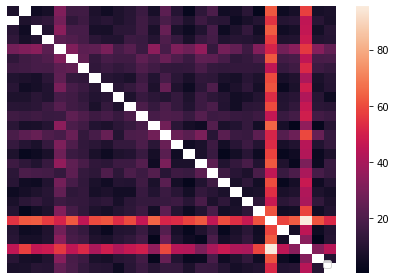

In [41]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()

In [42]:
def show_audio(comparison):
    distance, leftid, rightid = comparison
    print(distance)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i - display_count])

0.6627452204713682


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


1.6003441387170667


1.8007896829848824


1.9487404336734686


2.3956024930747923


62.42667039964427


62.90792712401582


63.0295825622699


64.58542914398421


95.39133189445998
